<a href="https://colab.research.google.com/github/FranMoritz/Projetos/blob/main/EDA_ENEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OBJETIVO DA EDA**

Essa análise tem como objetivo fazer uma exploração dos dados para o entendimento e criação de insights para melhoramento do programa ENEM.

# **Entrega Executiva**

O conjunto revela um perfil socioeconômico intermediário-baixo, com boa penetração tecnológica (celular e internet), mas restrições de renda e escolaridade. Isso pode afetar acesso à informação, desempenho escolar e escolha de curso.


---



Sugestão de Pergunta:

Estudantes com maior renda familiar média obtêm melhor desempenho na prova objetiva e na redação?

Existe diferença significativa nas notas entre faixas etárias dos participantes?

A origem escolar (pública ou privada) impacta de forma consistente o desempenho?


---


Valor para o negócio (educacional): Apoiar políticas de bolsas e reforço educacional para grupos de menor renda.





In [60]:
# ================================
# HEATMAP EXECUTIVO – V de Cramér
# ================================

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

# (opcional) Se tiver seaborn instalado, o heatmap fica mais limpo.
try:
    import seaborn as sns
    HAS_SNS = True
except:
    HAS_SNS = False

# ---------- 1) Helpers ----------

def cramers_v_corrected(confusion):
    """
    V de Cramér com correção de bias (Bergsma, 2013).
    confusion = pd.crosstab(...)
    """
    chi2 = st.chi2_contingency(confusion, correction=False)[0]
    n = confusion.to_numpy().sum()
    r, k = confusion.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def chi2_pvalue(confusion):
    """ Retorna p-valor do teste Qui-quadrado (sem correção de Yates). """
    chi2, p, dof, exp = st.chi2_contingency(confusion, correction=False)
    return p

def to_ordered_cat(s, order=None):
    """ Converte Series para categoria (ordenada se order for passado e estiver contido). """
    if order is not None:
        # usa apenas categorias que existem na coluna
        order_present = [x for x in order if x in set(s.dropna().unique())]
        if len(order_present) >= 2:
            return pd.Categorical(s, categories=order_present, ordered=True)
    return s.astype("category")

# ---------- 2) Selecione colunas ----------

# Alvo (renomeie se na sua base o nome for outro)
target = "RENDA_MES_FAM"

# Candidatas categóricas relevantes (use as que existirem na sua base)
candidates = [
    "ESCOLAR_PAI", "ESCOLAR_MAE",
    "OCUPACAO_PAI", "OCUPACAO_MAE",
    "POSSUI_WIFI", "POSSUI_COMPUTADOR",
    "POSSUI_CARRO", "POSSUI_MOTOC",
    "POSSUI_GELADEIRA", "POSSUI_TV_ASSINAT"
]

df = df_amostra_ENEM_2024.copy()

available = [c for c in candidates if c in df.columns]
if target not in df.columns:
    raise ValueError(f"Coluna alvo '{target}' não encontrada no DataFrame.")

# ---------- 3) (Opcional) Ordens categoriais ----------

# Ajuste a ordem abaixo conforme seu dicionário. Exemplos comuns:
ordem_renda = [
    "A - Até R$ 1.045,00",
    "B - De R$ 1.045,01 a R$ 1.567,00",
    "C - De R$ 1.567,01 a R$ 2.090,00",
    "D - De R$ 2.090,01 a R$ 2.612,00",
    "E - De R$ 2.612,01 a R$ 3.134,00",
    "F - De R$ 3.134,01 a R$ 3.656,00",
    "G - De R$ 3.656,01 a R$ 4.178,00",
    "H - De R$ 4.178,01 a R$ 4.700,00",
    "I - De R$ 4.700,01 a R$ 5.222,00",
    "J - Acima de R$ 5.222,00",
    "Desconhecido"
]

ordem_escolaridade = [
    "Nunca estudou",
    "Fundamental incompleto",
    "Fundamental completo",
    "Médio incompleto",
    "Médio completo",
    "Superior incompleto",
    "Superior completo",
    "Pós-graduação",
    "Desconhecido"
]

# aplica ordenações quando fizer sentido
df[target] = to_ordered_cat(df[target], ordem_renda)
for col in available:
    if "ESCOLAR_" in col:
        df[col] = to_ordered_cat(df[col], ordem_escolaridade)
    else:
        # garante categórico
        df[col] = df[col].astype("category")

# ---------- 4) Calcula V de Cramér e p-valor ----------

v_results = {}
p_results = {}

for col in available:
    # dropa NA localmente para a dupla (target, col)
    sub = df[[target, col]].dropna()
    if sub.empty or sub[target].nunique() < 2 or sub[col].nunique() < 2:
        v_results[col] = np.nan
        p_results[col] = np.nan
        continue
    ct = pd.crosstab(sub[target], sub[col])
    v_results[col] = cramers_v_corrected(ct)
    p_results[col] = chi2_pvalue(ct)

v_series = pd.Series(v_results, name="cramers_v").sort_values(ascending=False)
p_series = pd.Series(p_results, name="p_value").reindex(v_series.index)

summary = pd.concat([v_series, p_series], axis=1)
summary


,cramers_v,p_value
POSSUI_TV_ASSINAT,0.454331,0.000000e+00
POSSUI_CARRO,0.403016,0.000000e+00
POSSUI_COMPUTADOR,0.387838,0.000000e+00
POSSUI_WIFI,0.352312,0.000000e+00
OCUPACAO_PAI,0.317775,0.000000e+00
OCUPACAO_MAE,0.298640,0.000000e+00
ESCOLAR_PAI,0.232729,0.000000e+00
POSSUI_GELADEIRA,0.216034,0.000000e+00
ESCOLAR_MAE,0.211334,0.000000e+00
POSSUI_MOTOC,0.063906,5.636184e-201


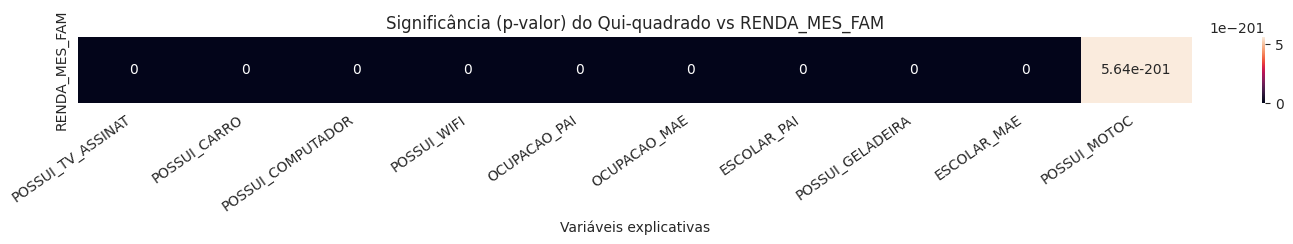

In [62]:
# --------------------------------
# 6) (Opcional) Heatmap – p-valor
# --------------------------------

pmat = p_series.to_frame().T
pmat.index = [target]

plt.figure(figsize=(min(1.2*len(p_series.index)+3, 18), 2.5))
if HAS_SNS:
    ax = sns.heatmap(pmat, annot=True, fmt=".3g", cbar=True)
    ax.set_title("Significância (p-valor) do Qui-quadrado vs RENDA_MES_FAM")
    ax.set_xlabel("Variáveis explicativas")
    ax.set_ylabel("")
    plt.xticks(rotation=35, ha="right")
else:
    im = plt.imshow(pmat.values, aspect="auto")
    plt.colorbar(im)
    for j, val in enumerate(pmat.values[0]):
        plt.text(j, 0, f"{val:.2g}", ha="center", va="center")
    plt.title("Significância (p-valor) do Qui-quadrado vs RENDA_MES_FAM")
    plt.yticks([0], [target])
    plt.xticks(range(pmat.shape[1]), pmat.columns, rotation=35, ha="right")
plt.tight_layout()
plt.show()


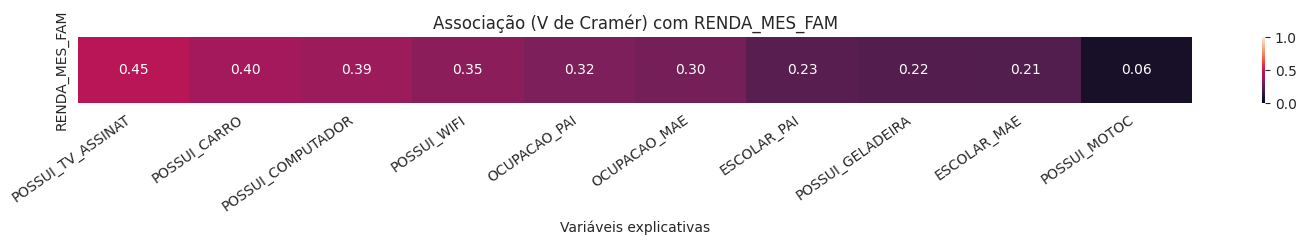

In [61]:
# -----------------------------
# 5) Heatmap – V de Cramér
# -----------------------------

mat = v_series.to_frame().T  # 1 linha (alvo) x N colunas (features)
mat.index = [target]

plt.figure(figsize=(min(1.2*len(v_series.index)+3, 18), 2.5))
if HAS_SNS:
    ax = sns.heatmap(mat, annot=True, fmt=".2f", vmin=0, vmax=1, cbar=True)
    ax.set_title("Associação (V de Cramér) com RENDA_MES_FAM")
    ax.set_xlabel("Variáveis explicativas")
    ax.set_ylabel("")
    plt.xticks(rotation=35, ha="right")
else:
    # fallback puro matplotlib
    im = plt.imshow(mat.values, aspect="auto", vmin=0, vmax=1)
    plt.colorbar(im)
    for j, val in enumerate(mat.values[0]):
        plt.text(j, 0, f"{val:.2f}", ha="center", va="center")
    plt.title("Associação (V de Cramér) com RENDA_MES_FAM")
    plt.yticks([0], [target])
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=35, ha="right")
plt.tight_layout()
plt.show()


O padrão é coerente com o perfil socioeconômico brasileiro: quanto maior o acesso a bens duráveis e serviços (TV paga, carro, computador), maior a renda.

Ocupação e escolaridade têm relação estatística real, mas menos intensa — refletem que educação e profissão influenciam a renda, mas não a explicam completamente.

Itens de alta penetração social (geladeira, moto) perderam poder discriminante: todo mundo tem, independentemente da renda.

# ETAPA 1 - Leitura dos dados e seleção da amostra

A base de dados original tem 4.3M de linhas. Pensando na performance da análise e com base nos recursos computacionais iremos trabalhar com uma amostra aleatória proporcional ao tamanho original.

In [1]:
#acessando o drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#importando as libs usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df_participantes_2024 = pd.read_csv("/content/gdrive/My Drive/EDA ENEM/PARTICIPANTES_2024.csv",
                            delimiter=';',
                            encoding='latin1' #'utf-8' 'latin1'
                            )

In [4]:
import pandas as pd

def amostra_inteligente(df, random_state=42):
    """
    Retorna uma amostra proporcional do DataFrame, mantendo todas as variáveis.
    A fração da amostra é escolhida automaticamente conforme o tamanho da base.
    O random_state garante que o resultado seja reproduzível
    (a mesma amostra toda vez que rodar).
    """

    n_total = len(df)

    # Define a fração de amostragem conforme o tamanho do dataset
    if n_total < 500_000:
        frac = 0.10   # 10%
    elif n_total < 2_000_000:
        frac = 0.05   # 5%
    else:
        frac = 0.02   # 2%

    print(f"Tamanho da base: {n_total:,} linhas.")
    print(f"Aplicando amostragem de {frac*100:.1f}% ({int(n_total * frac):,} linhas).")

    # Cria a amostra
    df_amostra = df.sample(frac=frac, random_state=random_state).reset_index(drop=True)

    return df_amostra


In [5]:
# Criando o DF com a amostra
df_amostra_ENEM_2024 = amostra_inteligente(df_participantes_2024)


Tamanho da base: 4,332,944 linhas.
Aplicando amostragem de 2.0% (86,658 linhas).


In [6]:
df_amostra_ENEM_2024.shape

(86659, 38)

# ETAPA 2 - Entendimento e tratamento dos dados

In [9]:
# Mostrando as primeiras linhas da tabela
df_amostra_ENEM_2024.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ENSINO,...,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023
0,210063332563,2024,2,F,1,1,1,2,0,1.0,...,A,B,B,A,B,A,B,A,C,A
1,210062254395,2024,9,M,1,1,1,1,6,NaN,...,B,A,A,A,B,A,B,B,C,A
2,210065772526,2024,4,F,1,1,1,1,1,NaN,...,A,A,A,A,A,A,A,A,C,A
3,210066094860,2024,1,F,1,1,1,3,0,NaN,...,A,B,B,A,C,B,B,C,E,E
4,210063502867,2024,1,F,1,1,1,3,0,NaN,...,B,B,B,A,D,B,B,C,E,A


**DICIONÁRIO DE DADOS**

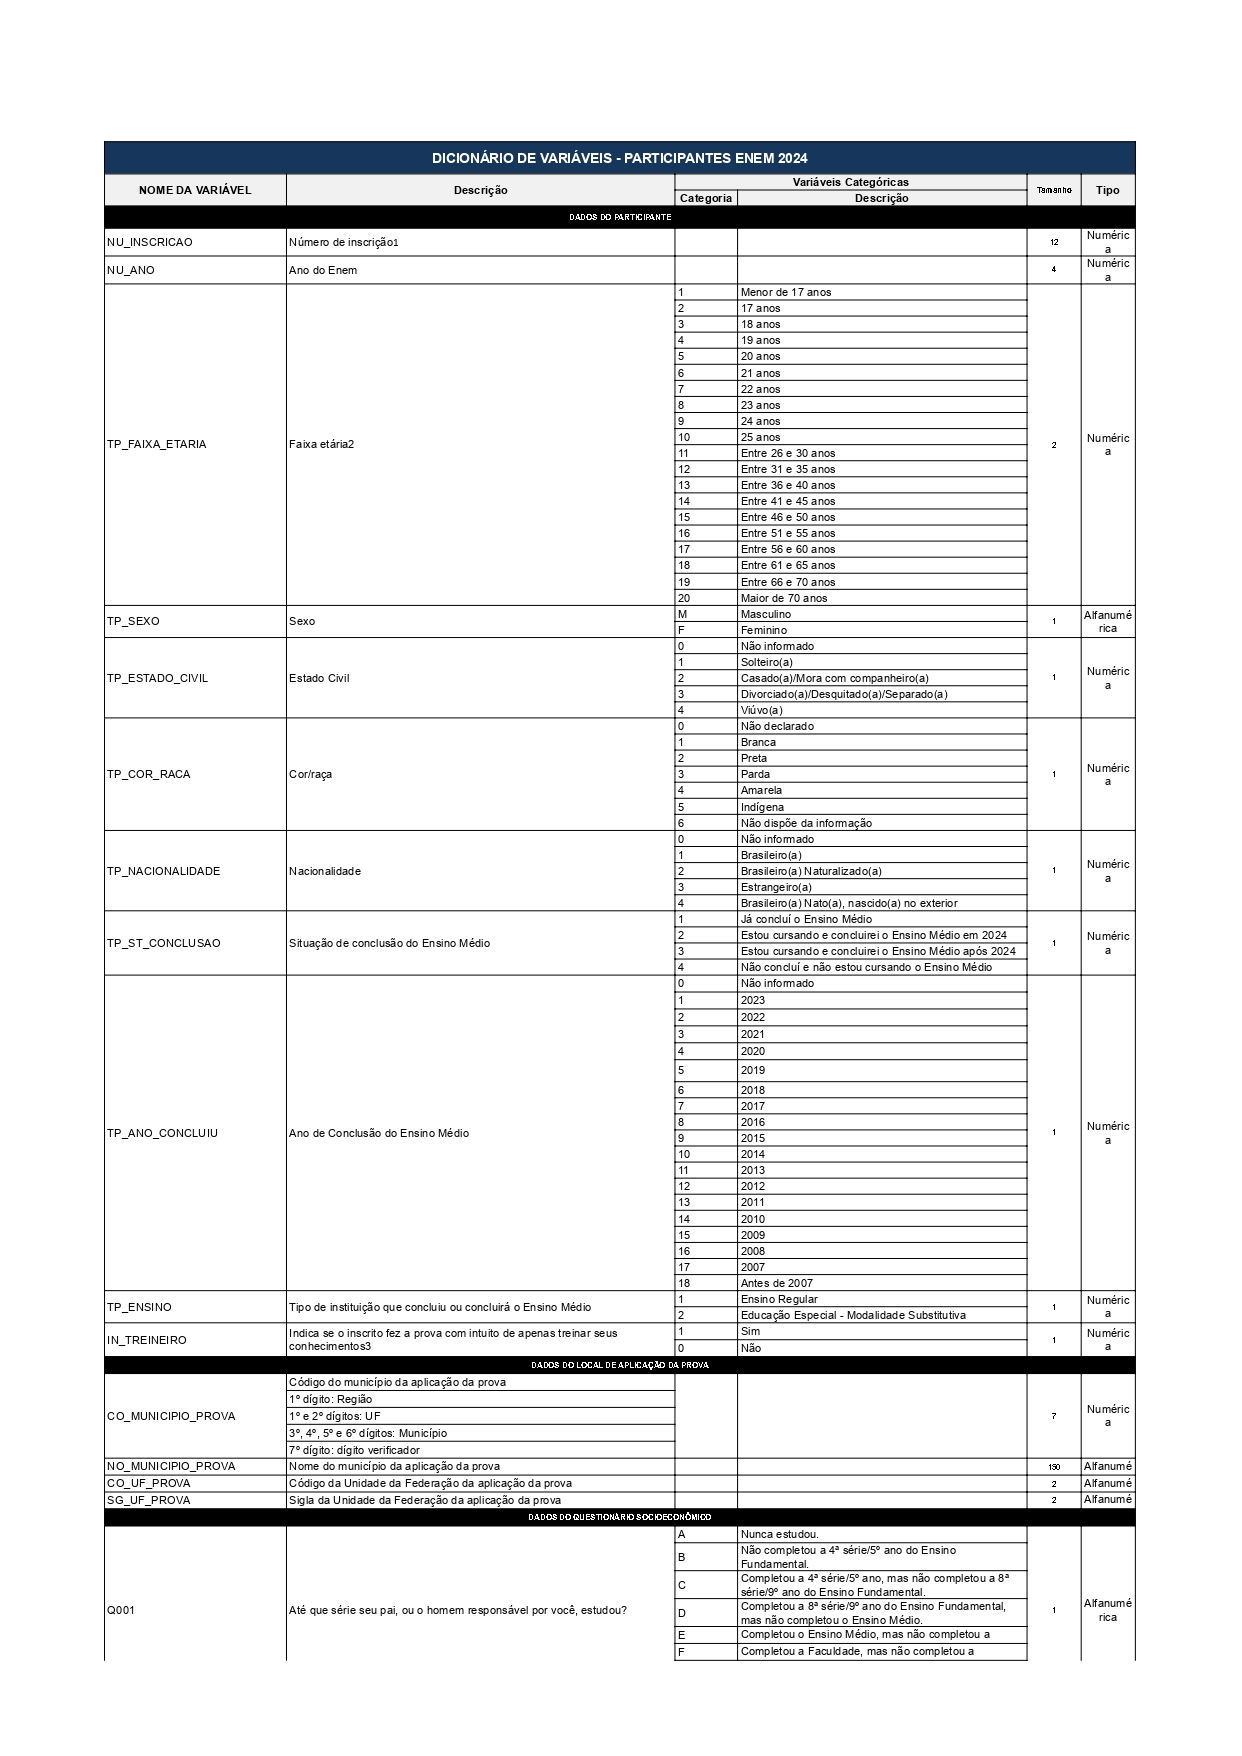

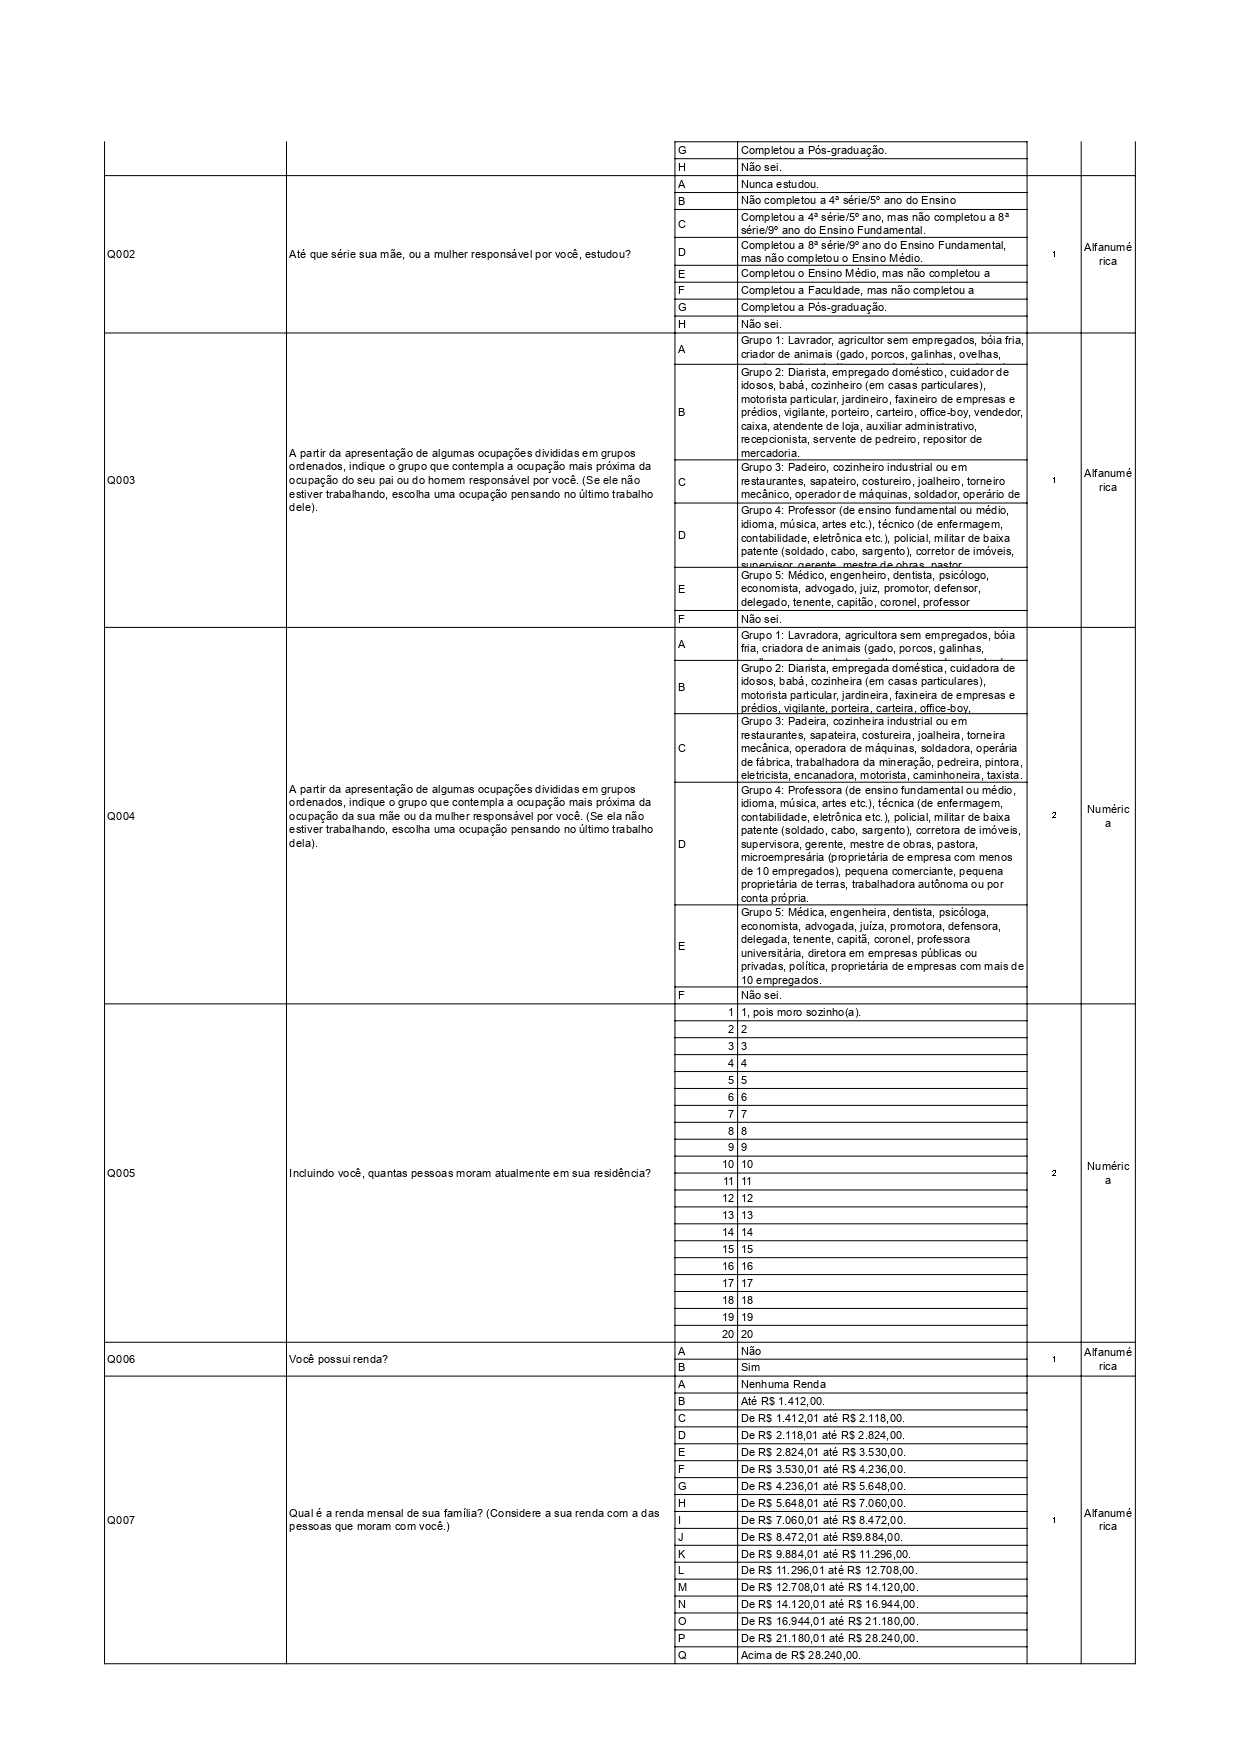

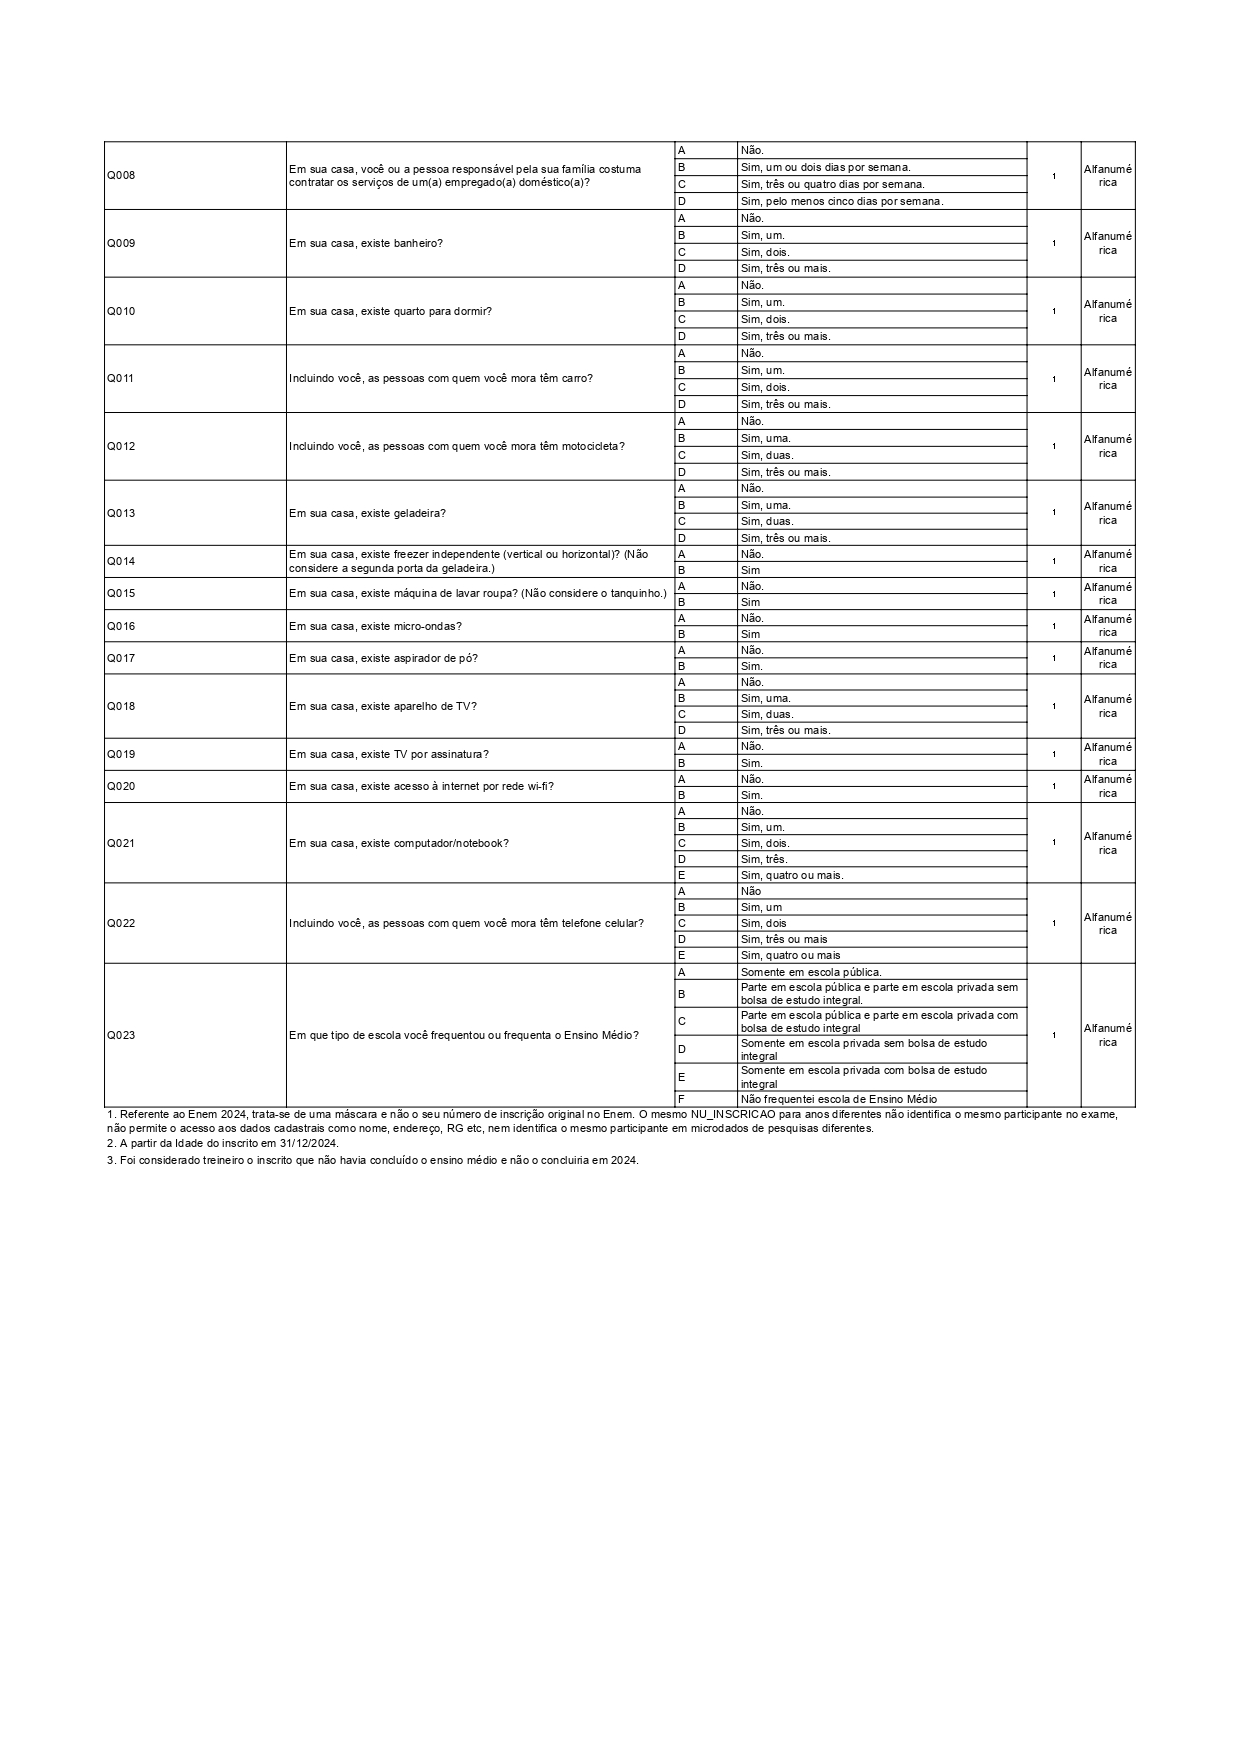

In [11]:
# Verificando os tipos das variáveis
df_amostra_ENEM_2024.dtypes

,0
NU_INSCRICAO,int64
NU_ANO,int64
TP_FAIXA_ETARIA,int64
TP_SEXO,object
TP_ESTADO_CIVIL,int64
TP_COR_RACA,int64
TP_NACIONALIDADE,int64
TP_ST_CONCLUSAO,int64
TP_ANO_CONCLUIU,int64
TP_ENSINO,float64


**Optei por renomear algumas colunas para melhor entedimento gráfico**


---



In [19]:
# Renomeando algumas colunas
df_amostra_ENEM_2024 = df_amostra_ENEM_2024.rename(columns={
    'Q001': 'ESCOLAR_PAI',
    'Q002': 'ESCOLAR_MAE',
    'Q003': 'OCUPACAO_PAI',
    'Q004': 'OCUPACAO_MAE',
    'Q005': 'QTDE_MORAD_RES',
    'Q006': 'POSSUI_RENDA',
    'Q007': 'RENDA_MES_FAM',
    'Q008': 'POSSUI_EMP_DOMESTICA',
    'Q009': 'CASA_POSSUI_WC',
    'Q010': 'CASA_POSSUI_DORM',
    'Q011': 'POSSUI_CARRO',
    'Q012': 'POSSUI_MOTOC',
    'Q013': 'POSSUI_GELADEIRA',
    'Q014': 'POSSUI_FREEZER',
    'Q015': 'POSSUI_MAQ_LAVAR',
    'Q016': 'POSSUI_MICROONDAS',
    'Q017': 'POSSUI_ASP_PO',
    'Q018': 'POSSUI_TV',
    'Q019': 'POSSUI_TV_ASSINAT',
    'Q020': 'POSSUI_WIFI',
    'Q021': 'POSSUI_COMPUTADOR',
    'Q022': 'POSSUI_CELULAR',
    'Q023': 'MOD_ESCOLAR_FREQ'
})


In [20]:
# Visualização da tabela renomeada
df_amostra_ENEM_2024.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ENSINO,...,POSSUI_FREEZER,POSSUI_MAQ_LAVAR,POSSUI_MICROONDAS,POSSUI_ASP_PO,POSSUI_TV,POSSUI_TV_ASSINAT,POSSUI_WIFI,POSSUI_COMPUTADOR,POSSUI_CELULAR,MOD_ESCOLAR_FREQ
0,210063332563,2024,2,F,1,1,1,2,0,1.0,...,A,B,B,A,B,A,B,A,C,A
1,210062254395,2024,9,M,1,1,1,1,6,NaN,...,B,A,A,A,B,A,B,B,C,A
2,210065772526,2024,4,F,1,1,1,1,1,NaN,...,A,A,A,A,A,A,A,A,C,A
3,210066094860,2024,1,F,1,1,1,3,0,NaN,...,A,B,B,A,C,B,B,C,E,E
4,210063502867,2024,1,F,1,1,1,3,0,NaN,...,B,B,B,A,D,B,B,C,E,A


In [29]:
# Visualização dos metadados
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

# Testando a função com o dataframe
metadata_df = generate_metadata(df_amostra_ENEM_2024)
metadata_df

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NU_INSCRICAO,int64,0,0.0,86659
1,QTDE_MORAD_RES,int64,0,0.0,20
2,CO_UF_PROVA,int64,0,0.0,27
3,IN_TREINEIRO,int64,0,0.0,2
4,TP_ANO_CONCLUIU,int64,0,0.0,19
5,TP_ST_CONCLUSAO,int64,0,0.0,4
6,CO_MUNICIPIO_PROVA,int64,0,0.0,1750
7,TP_COR_RACA,int64,0,0.0,6
8,TP_ESTADO_CIVIL,int64,0,0.0,5
9,NU_ANO,int64,0,0.0,1


TP_ENSINO	float64: Temos 55780 nulos. Optei por preencher com 'Desconhecido'

---





In [25]:
# Preecnhendo nulo da coluna específica
cols = ['TP_ENSINO']
df_amostra_ENEM_2024[cols] = df_amostra_ENEM_2024[cols].fillna('Desconhecido')


In [27]:
# Trocando Desconhecido por 0 - variável numérica
df_amostra_ENEM_2024 = df_amostra_ENEM_2024.replace('Desconhecido', 0)


/tmp/ipython-input-2132382381.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_amostra_ENEM_2024 = df_amostra_ENEM_2024.replace('Desconhecido', 0)


# ANÁLISE DESCRITIVAS

In [28]:
# Estatística variáveis categóricas
df_amostra_ENEM_2024.describe(include=['object', 'category'])

,TP_SEXO,NO_MUNICIPIO_PROVA,SG_UF_PROVA,ESCOLAR_PAI,ESCOLAR_MAE,OCUPACAO_PAI,OCUPACAO_MAE,POSSUI_RENDA,RENDA_MES_FAM,POSSUI_EMP_DOMESTICA,...,POSSUI_FREEZER,POSSUI_MAQ_LAVAR,POSSUI_MICROONDAS,POSSUI_ASP_PO,POSSUI_TV,POSSUI_TV_ASSINAT,POSSUI_WIFI,POSSUI_COMPUTADOR,POSSUI_CELULAR,MOD_ESCOLAR_FREQ
count,86659,86659,86659,86659,86659,86659,86659,86659,86659,86659,...,86659,86659,86659,86659,86659,86659,86659,86659,86659,86659
unique,2,1714,27,8,8,6,6,2,17,4,...,2,2,2,2,4,2,2,5,5,6
top,F,São Paulo,SP,E,E,C,B,A,B,A,...,A,B,A,A,B,A,B,A,D,A
freq,52555,3397,13143,24909,30552,19619,34589,62628,28428,79647,...,75479,53091,46520,66232,55357,68695,75982,42265,25036,65721


Anotações:


1) Maioria das pessoas que participam da prova são do sexo feminino;

2) Estado de São Paulo e cidade de São Paulo com maior número de participantes;

3) Escolaridade do pai e da mãe a maioria completou o ensino medio mas não completou ensino superior;

4) A grande maioria dos participantes não possui renda;

6) Quanto a renda mensal da família a grande maioria responder que é até R$ 1.412,00.

7) Grande maioria dos participantes possui 1 TV em casa;

8) Incluindo o participante e a fámilia possuem ao todo 3 ou mais aparelhos celular;

9) E a grande maioria estuda ou estudou o em escola pública;








In [30]:
# Estatística variáveis numéricas
df_amostra_ENEM_2024.describe()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_PROVA,CO_UF_PROVA,QTDE_MORAD_RES
count,8.665900e+04,86659.0,86659.000000,86659.000000,86659.000000,86659.000000,86659.000000,86659.000000,86659.000000,86659.000000,8.665900e+04,86659.000000,86659.000000
mean,2.100643e+11,2024.0,4.812322,1.036869,2.043019,1.030337,1.778742,2.279590,0.358359,0.194717,3.111527e+06,30.968728,3.696339
std,1.276844e+06,0.0,3.838126,0.413922,1.001531,0.225926,0.771393,4.529973,0.483738,0.395985,9.954915e+05,9.926128,1.422886
min,2.100621e+11,2024.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.100015e+06,11.000000,1.000000
25%,2.100632e+11,2024.0,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.408102e+06,24.000000,3.000000
50%,2.100643e+11,2024.0,3.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.126109e+06,31.000000,4.000000
75%,2.100654e+11,2024.0,6.000000,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,0.000000,3.550308e+06,35.000000,4.000000
max,2.100665e+11,2024.0,20.000000,4.000000,5.000000,4.000000,4.000000,18.000000,2.000000,1.000000,5.300108e+06,53.000000,20.000000


Anotações:

1)A maioria dos participantes estão entre os 18 e 19 anos;

2)São solteiros;

3)Maioria são cor/raça preta;

4)A grande maioria já havia concluido ou estava concluindo o ensino médio no ano de 2024;

5)Na maioria as residências possuem entre 3 e 4 moradores;

# **ETAPA 2 - Correlação de Pearson**

Verificar as variáveis que apontam para a mesma informação

In [32]:
# Função para gerar um DF da correlação de Pearson
def pearson_pairs(df_amostra_ENEM_2024, absolute=True, min_abs=0.0):
    # pega só colunas numéricas
    num = df_amostra_ENEM_2024.select_dtypes(include='number')
    # correlação de Pearson
    corr = num.corr(method='pearson')

    # pega apenas o triângulo superior (sem diagonal) para evitar pares duplicados
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    corr_tri = corr.where(mask)

    # transforma em formato longo
    out = (
        corr_tri.stack()
        .reset_index()
        .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
    )

    # ordenar por |corr| (ou por corr direto, se absolute=False)
    if absolute:
        out['abs_corr'] = out['corr'].abs()
        out = out.sort_values('abs_corr', ascending=False)
        # filtrar por limiar de |corr|
        out = out[out['abs_corr'] >= min_abs].reset_index(drop=True)
    else:
        out = out.sort_values('corr', ascending=False).reset_index(drop=True)

    return out

# uso:
# df_corr = pearson_pairs(df, absolute=True, min_abs=0.3)
# df_corr.head(20)


In [37]:
df_corr = pearson_pairs(df_amostra_ENEM_2024, absolute=True, min_abs=0.0)

In [39]:
df_corr.head(38)

,var1,var2,corr,abs_corr
0,CO_MUNICIPIO_PROVA,CO_UF_PROVA,0.999871,0.999871
1,TP_FAIXA_ETARIA,TP_ANO_CONCLUIU,0.798076,0.798076
2,TP_ST_CONCLUSAO,IN_TREINEIRO,0.778506,0.778506
3,TP_FAIXA_ETARIA,TP_ST_CONCLUSAO,-0.659147,0.659147
4,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,-0.508024,0.508024
5,TP_FAIXA_ETARIA,IN_TREINEIRO,-0.415159,0.415159
6,TP_FAIXA_ETARIA,TP_ENSINO,-0.379784,0.379784
7,TP_ANO_CONCLUIU,TP_ENSINO,-0.372798,0.372798
8,TP_ENSINO,IN_TREINEIRO,-0.364282,0.364282
9,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,0.318094,0.318094


Observações:





Poucas variáveis com correlação maior que 0.7, neste caso como são poucas variáveis optei por manter todas dentro da análise.

Com relação a variável cidade que tem alta cardinalidade, optei por criar um ranking com o top 5 cidades. É uma variável importante dentro da análise.

# **ETAPA 3 - Gráficos**

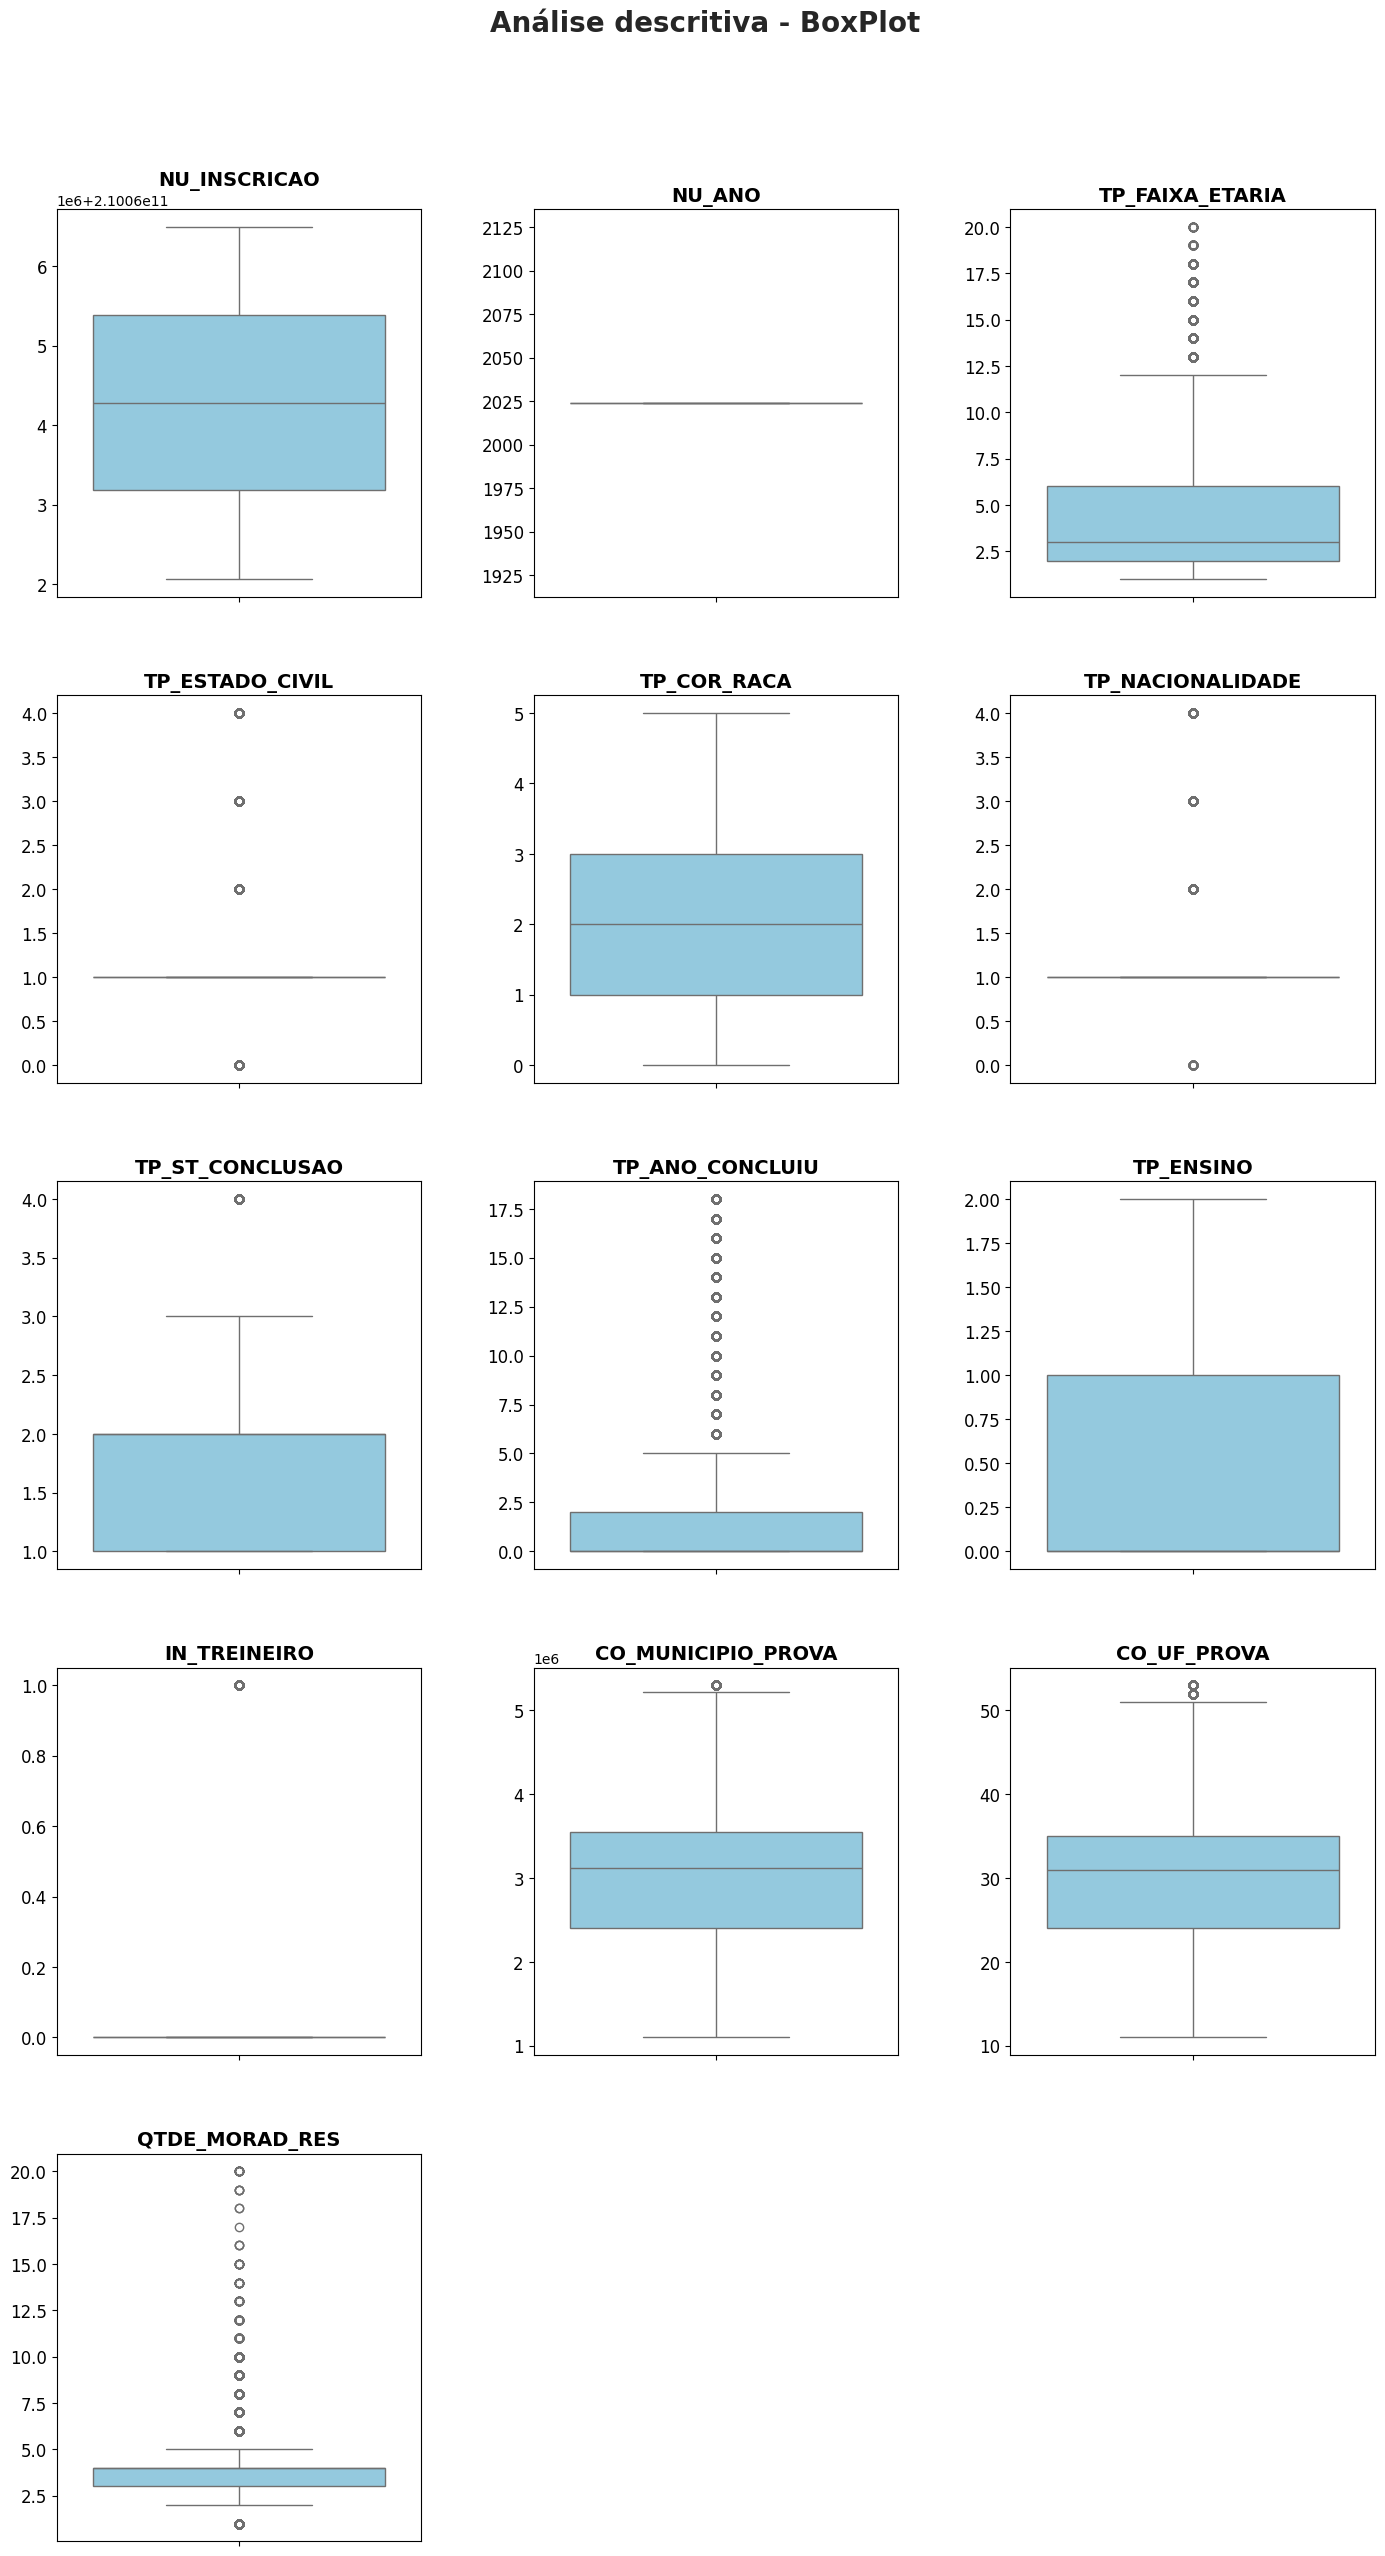

In [40]:
def pod_academy_box_plot(dataframe):
    """
    Plota boxplots estilizados com título simplificado para todas as variáveis numéricas do dataframe fornecido
    em um painel com 3 gráficos por linha.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=dataframe[column], ax=axes[i//3, i%3], color="skyblue")
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - BoxPlot", fontsize=20, fontweight='bold', y=1.05)

# Plotando os boxplots estilizados com títulos simplificados usando a função definida
pod_academy_box_plot(df_amostra_ENEM_2024)

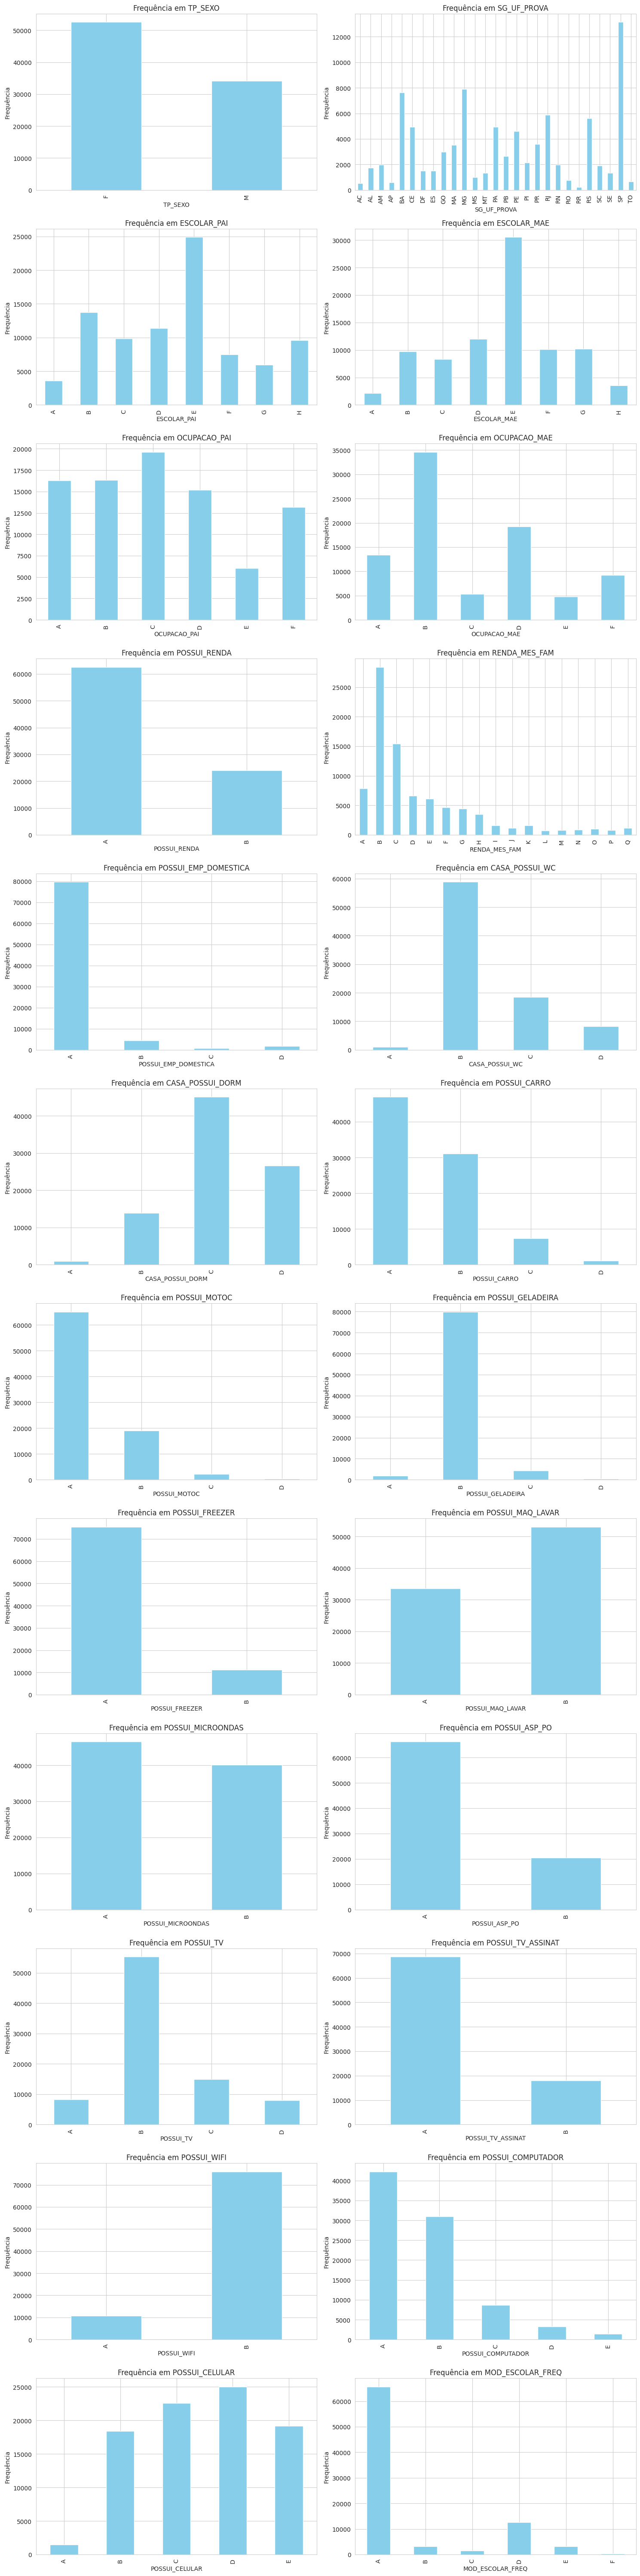

In [41]:
def plot_categorical_frequency_pt(df, corte_cardinalidade=30, graficos_por_linha=2):
    """
    Plota a frequência de categorias para variáveis categóricas em um DataFrame.

    Parâmetros:
    - df: DataFrame para plotagem.
    - corte_cardinalidade: Cardinalidade máxima para uma coluna ser considerada (padrão é 30).
    - graficos_por_linha: Quantidade de gráficos por linha (padrão é 3).

    Retorna:
    - Exibe os gráficos de barras.
    """

    # Gera metadados para o DataFrame
    metadados = []
    for coluna in df.columns:
        metadados.append({
            'Variável': coluna,
            'Tipo': df[coluna].dtype,
            'Cardinalidade': df[coluna].nunique()
        })

    df_metadados = pd.DataFrame(metadados)

    # Filtra colunas com cardinalidade maior que o corte e tipos não numéricos
    variaveis_categoricas = df_metadados[(df_metadados['Cardinalidade'] <= corte_cardinalidade) & (df_metadados['Tipo'] == 'object')]

    # Calcula o número de linhas e colunas para os subplots
    n_linhas = -(-len(variaveis_categoricas) // graficos_por_linha)  # Ceiling division
    n_colunas = min(len(variaveis_categoricas), graficos_por_linha)

    # Plota as variáveis categóricas
    fig, axs = plt.subplots(nrows=n_linhas, ncols=n_colunas, figsize=(15, 5 * n_linhas))

    for i, (idx, linha) in enumerate(variaveis_categoricas.iterrows()):
        var = linha['Variável']
        ax = axs[i // graficos_por_linha, i % graficos_por_linha]
        df[var].value_counts().sort_index().plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'Frequência em {var}')
        ax.set_ylabel('Frequência')
        ax.set_xlabel(var)

    # Remove os eixos vazios, se houver
    for j in range(i + 1, n_linhas * n_colunas):
        axs[j // graficos_por_linha, j % graficos_por_linha].axis('off')

    plt.tight_layout()
    plt.show()

# Testa a função com os dados e o corte padrão de cardinalidade
plot_categorical_frequency_pt(df_amostra_ENEM_2024, corte_cardinalidade=30, graficos_por_linha=2)

**Principais observações:**

TP_SEXO: há predominância feminina, indica uma maior participação de mulheres nas provas.

SG_UF_PROVA: ampla dispersão entre estados, mas há estados com picos de inscrições como São Paulo. É importante para entender concentração geográfica.

ESCOLAR_PAI e ESCOLAR_MAE: há predominância de escolaridade básica e média; poucos pais/mães possuem ensino superior. Isso pode influenciar o desempenho e é uma variável socioeconômica importante.

OCUPACAO_PAI e OCUPACAO_MAE: há concentração em ocupações básicas ou não especificadas, pode indicar limitação socioeconômica.

POSSUI_RENDA / RENDA_MES_FAM: maioria declara possuir renda, mas concentrada em faixas mais baixas, reforça o perfil socioeconômico modesto da amostra.

POSSUI_EMPREGO_DOMESTICA / CASA_PROPRIA / VEICULO / CELULAR / COMPUTADOR:

A maioria possui casa própria e celular, mas uma minoria possui veículos, empregada doméstica ou TV por assinatura.

Esse padrão mostra um perfil típico de famílias com estabilidade básica, mas com consumo restrito de bens de maior valor.

POSSUI_GELADEIRA, FREEZER, MAQ_LAVAR: quase universais — bens essenciais presentes na maioria dos lares.

POSSUI_WIFI: altíssima presença, mostrando digitalização crescente, apesar da renda modesta.

TP_FAIXA_ETARIA: mediana próxima a 3, com alguns outliers altos, maioria dos participantes é jovem, mas há presença de adultos (faixas 8 a 20). Isso mostra diversidade etária.

TP_ESTADO_CIVIL: predominância de solteiros.

TP_COR_RACA: distribuição mais concentrada em uma ou duas categorias, mas com dispersão, permite explorar possíveis desigualdades de desempenho por cor/raça.

TP_NACIONALIDADE: quase todos brasileiros.

TP_ST_CONCLUSAO: maioria concluiu ou está concluindo o ensino médio.

TP_ANO_CONCLUIU: presença de muitos outliers, indica ex-participantes de anos anteriores e candidatos recorrentes.

TP_ENSINO: maioria do ensino regular, poucos do EJA ou técnico.

IN_TREINEIRO: poucos outliers no valor 1 pequena parcela de candidatos treineiros.

,CIDADE_UF,QTDE_PROVAS
0,São Paulo / SP,3397
1,Rio de Janeiro / RJ,2392
2,Brasília / DF,1508
3,Salvador / BA,1425
4,Fortaleza / CE,1396


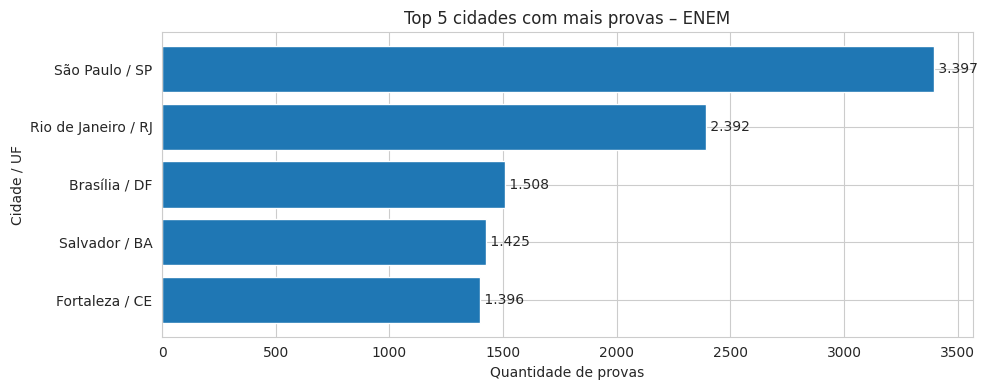

In [63]:
# Top 5 cidades com mais provas do ENEM

import pandas as pd
import matplotlib.pyplot as plt


df_base = df_amostra_ENEM_2024

# 1) Detecta colunas candidatas de Cidade e UF
city_candidates = [
    "NO_MUNICIPIO_PROVA", "NO_MUNICIPIO_RESIDENCIA",
    "MUNICIPIO", "CIDADE_PROVA", "CIDADE"
]
uf_candidates = [
    "SG_UF_PROVA", "SG_UF_RESIDENCIA", "UF", "UF_PROVA"
]

city_col = next((c for c in city_candidates if c in df_base.columns), None)
uf_col   = next((c for c in uf_candidates if c in df_base.columns), None)

if city_col is None:
    raise ValueError("Não encontrei coluna de cidade. Verifique o nome (ex.: NO_MUNICIPIO_PROVA).")

# 2) Cria uma coluna 'CIDADE_UF' para desambiguar cidades homônimas
if uf_col is not None:
    cidade_uf = (df_base[city_col].astype(str).str.strip() + " / " +
                 df_base[uf_col].astype(str).str.strip())
else:
    cidade_uf = df_base[city_col].astype(str).str.strip()

# 3) Conta provas por cidade
rank_cidades = (
    cidade_uf.value_counts(dropna=True)
              .rename_axis("CIDADE_UF")
              .reset_index(name="QTDE_PROVAS")
)

# 4) Top 5
top5 = rank_cidades.head(5)

# 5) Tabela (útil para relatório)
display(top5)

# 6) Plot – barras horizontais (legível para nomes longos)
plt.figure(figsize=(10, 4))
plt.barh(top5["CIDADE_UF"][::-1], top5["QTDE_PROVAS"][::-1])  # inverte para maior no topo
for i, v in enumerate(top5["QTDE_PROVAS"][::-1]):
    plt.text(v, i, f" {v:,}".replace(",", "."), va="center")  # anota valores

plt.title("Top 5 cidades com mais provas – ENEM")
plt.xlabel("Quantidade de provas")
plt.ylabel("Cidade / UF")
plt.tight_layout()
plt.show()


# ANÁLISE DE RELAÇÃO

Tabela de contingência:


OCUPACAO_PAI,A,B,C,D,E,F
RENDA_MES_FAM,,,,,,
A,3170,1311,1082,298,84,1899
B,8440,6664,5934,1850,238,5302
C,2303,3792,4517,2033,273,2489
D,817,1394,2036,1223,195,936
E,536,1109,1952,1496,251,739
F,325,741,1409,1388,281,488
G,240,570,1131,1582,426,457
H,156,363,704,1530,488,285
I,61,127,272,716,273,134


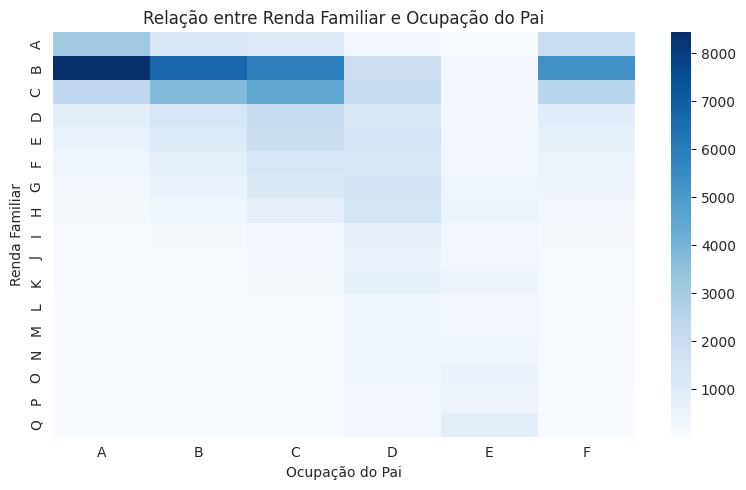

Teste Qui-quadrado:
χ² = 43831.95, gl = 80, p = 0.0000
V de Cramér = 0.318
→ Associação estatisticamente significativa entre Renda Familiar e Ocupação do Pai.
→ A força da associação é forte.


In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from math import sqrt

# --- 1. Tabela de contingência ---
tabela = pd.crosstab(df_amostra_ENEM_2024['RENDA_MES_FAM'],
                     df_amostra_ENEM_2024['OCUPACAO_PAI'])

print("Tabela de contingência:")
display(tabela)

# --- 2. Mapa de calor (Heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(tabela, cmap="Blues", annot=False, fmt="g")
plt.title("Relação entre Renda Familiar e Ocupação do Pai")
plt.ylabel("Renda Familiar")
plt.xlabel("Ocupação do Pai")
plt.tight_layout()
plt.show()

# --- 3. Teste Qui-quadrado ---
chi2, p, dof, expected = chi2_contingency(tabela)
print(f"Teste Qui-quadrado:\nχ² = {chi2:.2f}, gl = {dof}, p = {p:.4f}")

# --- 4. V de Cramér (força da associação) ---
n = tabela.sum().sum()
r, k = tabela.shape
v_cramer = sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"V de Cramér = {v_cramer:.3f}")

# --- 5. Interpretação automática ---
if p < 0.05:
    print("→ Associação estatisticamente significativa entre Renda Familiar e Ocupação do Pai.")
else:
    print("→ Não há evidência estatística de associação significativa (p ≥ 0.05).")

if v_cramer < 0.1:
    força = "fraca"
elif v_cramer < 0.3:
    força = "moderada"
else:
    força = "forte"

print(f"→ A força da associação é {força}.")


Tabela de contingência:


OCUPACAO_MAE,A,B,C,D,E,F
RENDA_MES_FAM,,,,,,
A,3007,2751,290,427,58,1311
B,7325,13683,1554,2418,203,3245
C,1690,7891,1276,2710,192,1648
D,509,3000,634,1641,182,635
E,336,2466,522,1954,237,568
F,202,1614,358,1809,219,430
G,122,1275,274,2046,330,359
H,75,747,201,1769,450,284
I,36,300,67,793,256,131


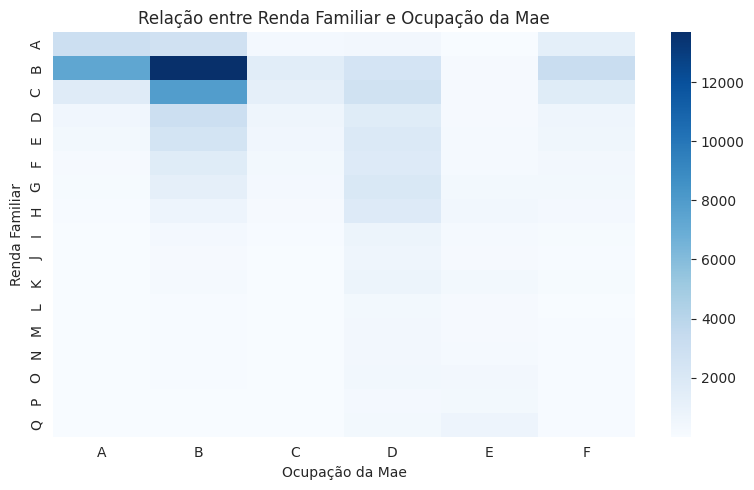

Teste Qui-quadrado:
χ² = 38721.61, gl = 80, p = 0.0000
V de Cramér = 0.299
→ Associação estatisticamente significativa entre Renda Familiar e Ocupação da Mae.
→ A força da associação é moderada.


In [54]:
# --- 1. Tabela de contingência ---
tabela = pd.crosstab(df_amostra_ENEM_2024['RENDA_MES_FAM'],
                     df_amostra_ENEM_2024['OCUPACAO_MAE'])

print("Tabela de contingência:")
display(tabela)

# --- 2. Mapa de calor (Heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(tabela, cmap="Blues", annot=False, fmt="g")
plt.title("Relação entre Renda Familiar e Ocupação da Mae")
plt.ylabel("Renda Familiar")
plt.xlabel("Ocupação da Mae")
plt.tight_layout()
plt.show()

# --- 3. Teste Qui-quadrado ---
chi2, p, dof, expected = chi2_contingency(tabela)
print(f"Teste Qui-quadrado:\nχ² = {chi2:.2f}, gl = {dof}, p = {p:.4f}")

# --- 4. V de Cramér (força da associação) ---
n = tabela.sum().sum()
r, k = tabela.shape
v_cramer = sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"V de Cramér = {v_cramer:.3f}")

# --- 5. Interpretação automática ---
if p < 0.05:
    print("→ Associação estatisticamente significativa entre Renda Familiar e Ocupação da Mae.")
else:
    print("→ Não há evidência estatística de associação significativa (p ≥ 0.05).")

if v_cramer < 0.1:
    força = "fraca"
elif v_cramer < 0.3:
    força = "moderada"
else:
    força = "forte"

print(f"→ A força da associação é {força}.")

Tabela de contingência:


POSSUI_CARRO,A,B,C,D
RENDA_MES_FAM,,,,
A,7076,684,69,15
B,23227,4912,242,47
C,9001,5882,480,44
D,2795,3380,388,38
E,1967,3530,530,56
F,1080,2908,574,70
G,779,2819,722,86
H,447,2199,787,93
I,170,912,438,63


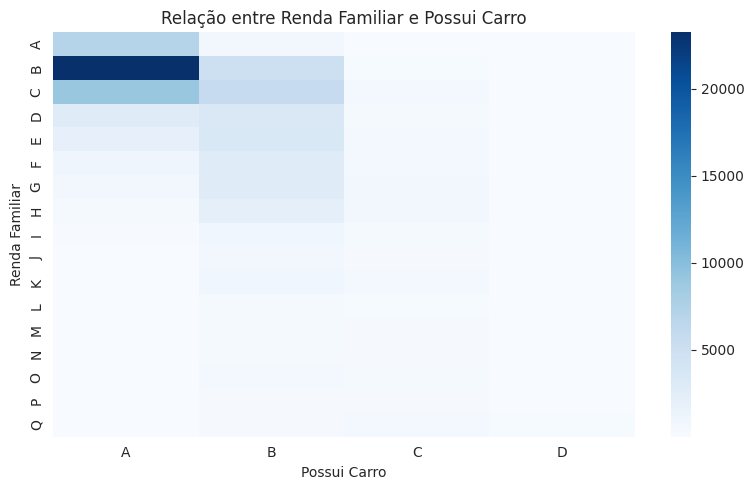

Teste Qui-quadrado:
χ² = 42272.46, gl = 48, p = 0.0000
V de Cramér = 0.403
→ Associação estatisticamente significativa entre Renda Familiar e Possui Carro.
→ A força da associação é forte.


In [55]:
# --- 1. Tabela de contingência ---
tabela = pd.crosstab(df_amostra_ENEM_2024['RENDA_MES_FAM'],
                     df_amostra_ENEM_2024['POSSUI_CARRO'])

print("Tabela de contingência:")
display(tabela)

# --- 2. Mapa de calor (Heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(tabela, cmap="Blues", annot=False, fmt="g")
plt.title("Relação entre Renda Familiar e Possui Carro")
plt.ylabel("Renda Familiar")
plt.xlabel("Possui Carro")
plt.tight_layout()
plt.show()

# --- 3. Teste Qui-quadrado ---
chi2, p, dof, expected = chi2_contingency(tabela)
print(f"Teste Qui-quadrado:\nχ² = {chi2:.2f}, gl = {dof}, p = {p:.4f}")

# --- 4. V de Cramér (força da associação) ---
n = tabela.sum().sum()
r, k = tabela.shape
v_cramer = sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"V de Cramér = {v_cramer:.3f}")

# --- 5. Interpretação automática ---
if p < 0.05:
    print("→ Associação estatisticamente significativa entre Renda Familiar e Possui Carro.")
else:
    print("→ Não há evidência estatística de associação significativa (p ≥ 0.05).")

if v_cramer < 0.1:
    força = "fraca"
elif v_cramer < 0.3:
    força = "moderada"
else:
    força = "forte"

print(f"→ A força da associação é {força}.")

Tabela de contingência:


TP_COR_RACA,0,1,2,3,4,5
RENDA_MES_FAM,,,,,,
A,100,1798,1306,4359,162,119
B,332,7793,4510,15084,421,288
C,146,5935,2250,6794,196,86
D,85,3059,764,2608,60,25
E,55,3034,615,2289,71,19
F,53,2472,425,1599,63,20
G,45,2597,354,1348,49,13
H,38,2186,233,1014,43,12
I,13,1027,105,410,26,2


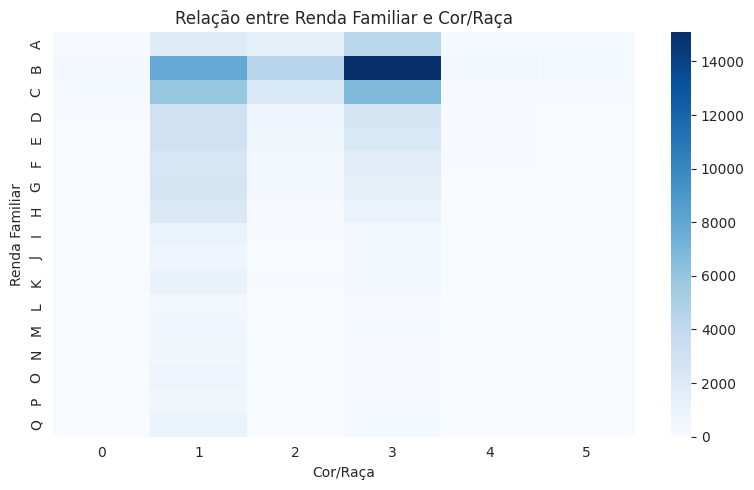

Teste Qui-quadrado:
χ² = 9182.89, gl = 80, p = 0.0000
V de Cramér = 0.146
→ Associação estatisticamente significativa entre Renda Familiar e Cor/Raça.
→ A força da associação é moderada.


In [56]:
# --- 1. Tabela de contingência ---
tabela = pd.crosstab(df_amostra_ENEM_2024['RENDA_MES_FAM'],
                     df_amostra_ENEM_2024['TP_COR_RACA'])

print("Tabela de contingência:")
display(tabela)

# --- 2. Mapa de calor (Heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(tabela, cmap="Blues", annot=False, fmt="g")
plt.title("Relação entre Renda Familiar e Cor/Raça")
plt.ylabel("Renda Familiar")
plt.xlabel("Cor/Raça")
plt.tight_layout()
plt.show()

# --- 3. Teste Qui-quadrado ---
chi2, p, dof, expected = chi2_contingency(tabela)
print(f"Teste Qui-quadrado:\nχ² = {chi2:.2f}, gl = {dof}, p = {p:.4f}")

# --- 4. V de Cramér (força da associação) ---
n = tabela.sum().sum()
r, k = tabela.shape
v_cramer = sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"V de Cramér = {v_cramer:.3f}")

# --- 5. Interpretação automática ---
if p < 0.05:
    print("→ Associação estatisticamente significativa entre Renda Familiar e Cor/Raça.")
else:
    print("→ Não há evidência estatística de associação significativa (p ≥ 0.05).")

if v_cramer < 0.1:
    força = "fraca"
elif v_cramer < 0.3:
    força = "moderada"
else:
    força = "forte"

print(f"→ A força da associação é {força}.")

Tabela de contingência:


ESCOLAR_PAI,A,B,C,D,E,F,G,H
RENDA_MES_FAM,,,,,,,,
A,860,2054,1008,939,1417,158,84,1324
B,1850,6503,4034,4159,6738,700,318,4126
C,485,2620,1956,2459,4880,759,368,1880
D,164,884,863,1028,2269,503,250,640
E,111,649,671,847,2416,617,267,505
F,72,405,450,604,1809,634,327,331
G,28,285,365,506,1690,777,469,286
H,19,143,220,348,1312,761,541,182
I,7,59,76,119,578,373,287,84


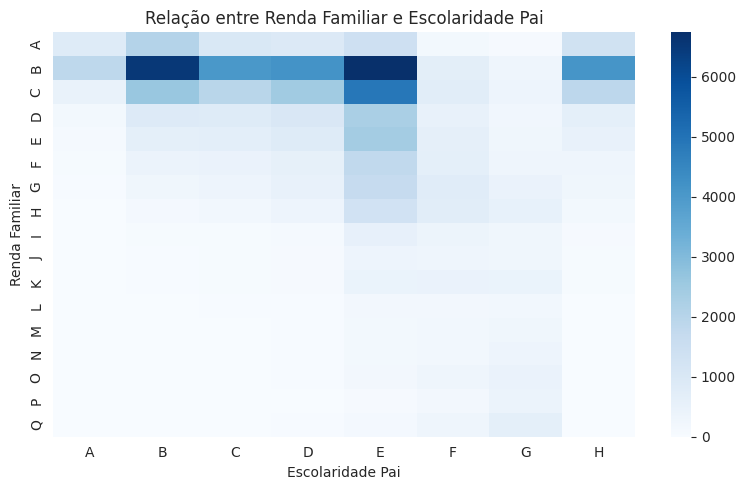

Teste Qui-quadrado:
χ² = 32965.11, gl = 112, p = 0.0000
V de Cramér = 0.233
→ Associação estatisticamente significativa entre Renda Familiar e Escolaridade Pai.
→ A força da associação é moderada.


In [58]:
# --- 1. Tabela de contingência ---
tabela = pd.crosstab(df_amostra_ENEM_2024['RENDA_MES_FAM'],
                     df_amostra_ENEM_2024['ESCOLAR_PAI'])

print("Tabela de contingência:")
display(tabela)

# --- 2. Mapa de calor (Heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(tabela, cmap="Blues", annot=False, fmt="g")
plt.title("Relação entre Renda Familiar e Escolaridade Pai")
plt.ylabel("Renda Familiar")
plt.xlabel("Escolaridade Pai")
plt.tight_layout()
plt.show()

# --- 3. Teste Qui-quadrado ---
chi2, p, dof, expected = chi2_contingency(tabela)
print(f"Teste Qui-quadrado:\nχ² = {chi2:.2f}, gl = {dof}, p = {p:.4f}")

# --- 4. V de Cramér (força da associação) ---
n = tabela.sum().sum()
r, k = tabela.shape
v_cramer = sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"V de Cramér = {v_cramer:.3f}")

# --- 5. Interpretação automática ---
if p < 0.05:
    print("→ Associação estatisticamente significativa entre Renda Familiar e Escolaridade Pai.")
else:
    print("→ Não há evidência estatística de associação significativa (p ≥ 0.05).")

if v_cramer < 0.1:
    força = "fraca"
elif v_cramer < 0.3:
    força = "moderada"
else:
    força = "forte"

print(f"→ A força da associação é {força}.")

Tabela de contingência:


ESCOLAR_MAE,A,B,C,D,E,F,G,H
RENDA_MES_FAM,,,,,,,,
A,532,1651,1101,1327,2226,264,183,560
B,1062,4767,3739,5126,10038,1362,769,1565
C,302,1696,1595,2598,6392,1375,830,619
D,100,563,620,947,2728,859,563,221
E,67,415,430,680,2586,941,781,183
F,35,256,289,467,1847,843,787,108
G,25,155,220,341,1562,950,1052,101
H,19,101,123,208,1067,863,1069,76
I,5,36,54,71,477,397,519,24


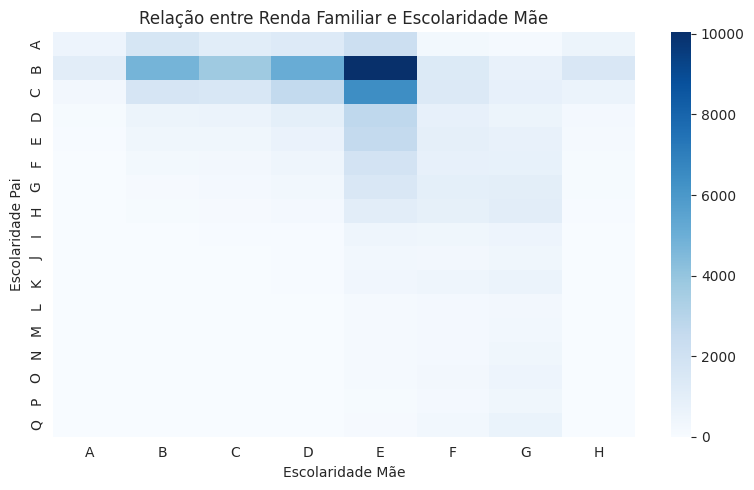

Teste Qui-quadrado:
χ² = 27202.46, gl = 112, p = 0.0000
V de Cramér = 0.212
→ Associação estatisticamente significativa entre Renda Familiar e Escolaridade Mãe.
→ A força da associação é moderada.


In [59]:
# --- 1. Tabela de contingência ---
tabela = pd.crosstab(df_amostra_ENEM_2024['RENDA_MES_FAM'],
                     df_amostra_ENEM_2024['ESCOLAR_MAE'])

print("Tabela de contingência:")
display(tabela)

# --- 2. Mapa de calor (Heatmap) ---
plt.figure(figsize=(8,5))
sns.heatmap(tabela, cmap="Blues", annot=False, fmt="g")
plt.title("Relação entre Renda Familiar e Escolaridade Mãe")
plt.ylabel("Escolaridade Pai")
plt.xlabel("Escolaridade Mãe")
plt.tight_layout()
plt.show()

# --- 3. Teste Qui-quadrado ---
chi2, p, dof, expected = chi2_contingency(tabela)
print(f"Teste Qui-quadrado:\nχ² = {chi2:.2f}, gl = {dof}, p = {p:.4f}")

# --- 4. V de Cramér (força da associação) ---
n = tabela.sum().sum()
r, k = tabela.shape
v_cramer = sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"V de Cramér = {v_cramer:.3f}")

# --- 5. Interpretação automática ---
if p < 0.05:
    print("→ Associação estatisticamente significativa entre Renda Familiar e Escolaridade Mãe.")
else:
    print("→ Não há evidência estatística de associação significativa (p ≥ 0.05).")

if v_cramer < 0.1:
    força = "fraca"
elif v_cramer < 0.3:
    força = "moderada"
else:
    força = "forte"

print(f"→ A força da associação é {força}.")